In [62]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import os
import argparse
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import ImageFile
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from tqdm import tqdm
import numpy as np
from dataset import PairedImagesDataset, sample_cvusa_images
from model import CrossviewModel, Dinov2Matcher, CosineSimilarityLoss, get_combined_embedding_visualization_all

In [63]:
# Sample paired images
dataset_path = r"D:\CVUSA\CVPR_subset"
train_filenames, val_filenames = sample_cvusa_images(dataset_path, sample_percentage=0.2, split_ratio=0.8, groundtype='panos')

# Settings
patch_scale = 1
image_size = 224 * patch_scale
aerial_scaling = 2
provide_paths = False
BATCH_SIZE = 1

transform_ground = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

transform_aerial = transforms.Compose([
    transforms.Resize((image_size*aerial_scaling, image_size*aerial_scaling)),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

# Instantiate the dataset and dataloader
paired_dataset = PairedImagesDataset(train_filenames, transform_aerial=transform_aerial, transform_ground=transform_ground, cutout_from_pano=True)
data_loader = DataLoader(paired_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define the Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the Model
model = CrossviewModel(backbone='dinov2', frozen=True).to(device)
model.show()

panos
Using device: cuda


Using cache found in C:\Users\russ_le/.cache\torch\hub\facebookresearch_dinov2_main





CrossviewModel(
  (original_model): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False

fov [tensor([90]), tensor([180])]
yaw tensor([60])
pitch tensor([90])
x1_img shape:  torch.Size([1, 3, 224, 224])
x2_img shape:  torch.Size([1, 3, 224, 224])
x1_dino shape:  torch.Size([1, 256, 768])
x2_dino shape:  torch.Size([1, 256, 768])
x1_cls shape:  torch.Size([1, 1, 768])
x2_cls shape:  torch.Size([1, 1, 768])
ground tokens shape: torch.Size([1, 256, 768])
aerial tokens shape: torch.Size([1, 256, 768])
num_patches_ground:  256
num_patches_aerial:  256
Ground image pixel values (min, max): 0.0 0.98039216
Aerial image pixel values (min, max): 0.003921569 0.7058824


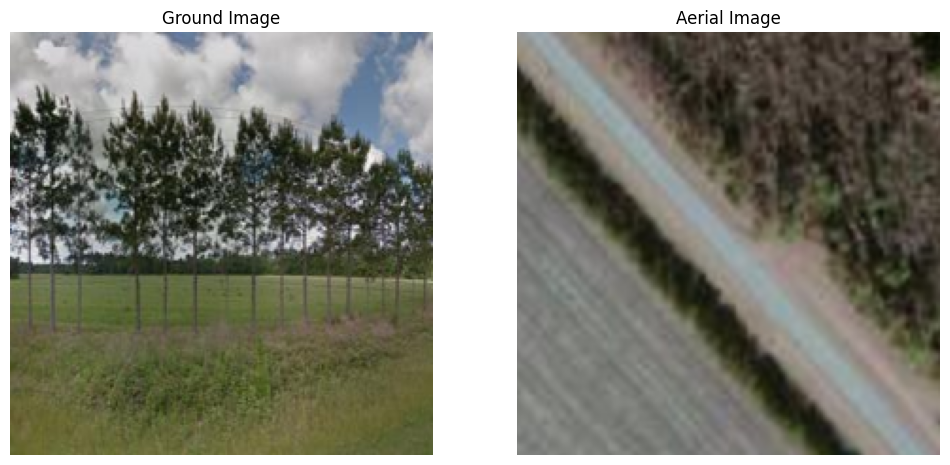

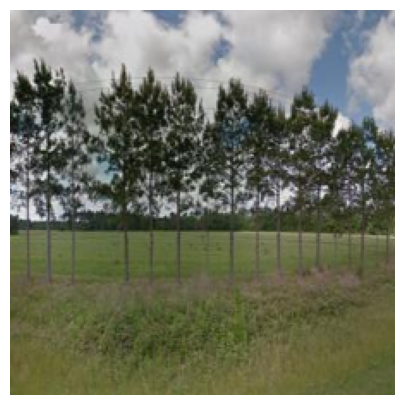

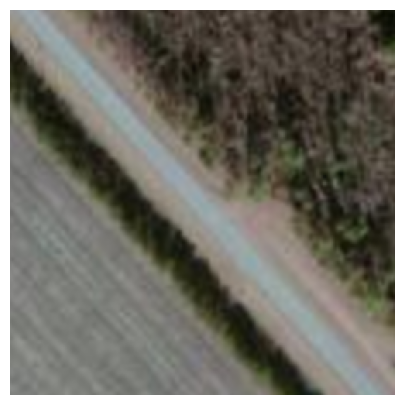

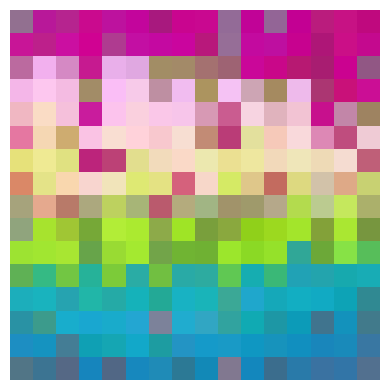

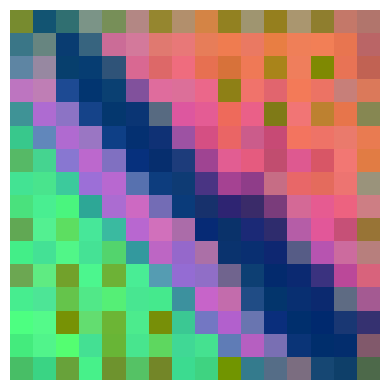

In [64]:
# Load a single pair of images
ground_image, aerial_image, fov, yaw, pitch = next(iter(data_loader))
ground_image = ground_image.to(device)
aerial_image = aerial_image.to(device)

print("fov", fov)
print("yaw", yaw)
print("pitch", pitch)

# Compute the output of the model
ground_tokens, aerial_tokens = model(ground_image, aerial_image, debug=True)

print("ground tokens shape:", ground_tokens.shape)
print("aerial tokens shape:", aerial_tokens.shape)

# Calculate the number of patches for ground and aerial images
num_patches_ground = (ground_image.shape[-1] // model.patch_size) * (ground_image.shape[-2] // model.patch_size)
num_patches_aerial = (aerial_image.shape[-1] // model.patch_size) * (aerial_image.shape[-2] // model.patch_size)
print("num_patches_ground: ", num_patches_ground)
print("num_patches_aerial: ", num_patches_aerial)

# Convert images to numpy for visualization
ground_image_np = ground_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()
aerial_image_np = aerial_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()

print("Ground image pixel values (min, max):", ground_image_np.min(), ground_image_np.max())
print("Aerial image pixel values (min, max):", aerial_image_np.min(), aerial_image_np.max())

# Plot the ground image and aerial image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ground_image_np)
ax[0].set_title("Ground Image")
ax[0].axis('off')
ax[1].imshow(aerial_image_np)
ax[1].set_title("Aerial Image")
ax[1].axis('off')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ground_image_np)
ax.axis('off')
plt.savefig(os.path.join("images", "ground_image.png"), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(aerial_image_np)
ax.axis('off')
plt.savefig(os.path.join("images", "aerial_image.png"), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

model.show_tokens(ground_tokens, mode='save', results_path=os.path.join("images", "ground_tokens.png"))
model.show_tokens(aerial_tokens, mode='save', results_path=os.path.join("images", "aerial_tokens.png"))

Using cache found in C:\Users\russ_le/.cache\torch\hub\facebookresearch_dinov2_main


ground_image shape: torch.Size([1, 3, 224, 224])
aerial_image shape: torch.Size([1, 3, 224, 224])
tokens_1 shape: (256, 768)
tokens_2 shape: (256, 768)
grid_size1: (16, 16)
grid_size2: (16, 16)
grid_size2_reduced: (16, 16)
resize_scale1: 1.0
resize_scale2: 1.0
tokens1.shape (256, 768)
tokens2.shape (256, 768)
reduced_tokens.shape (512, 3)


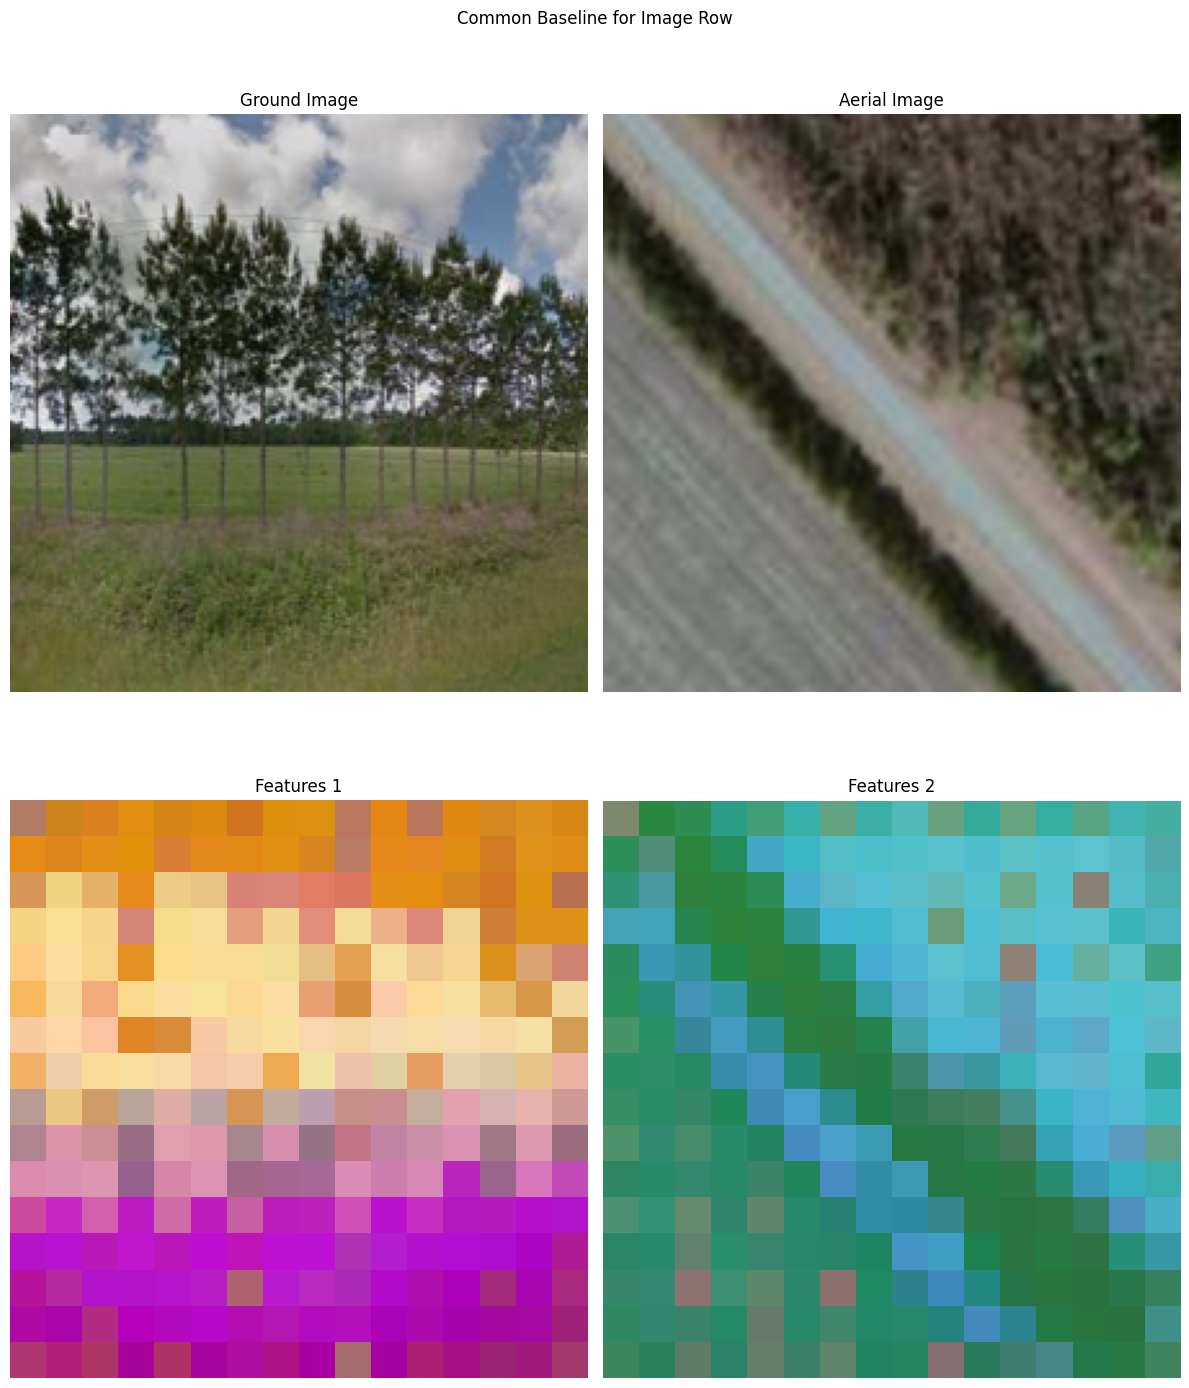

In [65]:
ground_image_vis = ground_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
aerial_image_vis = aerial_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
ground_image_vis = ground_image_vis.astype(np.uint8)
aerial_image_vis = aerial_image_vis.astype(np.uint8)

# Init Dinov2Matcher
dm = Dinov2Matcher()

# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(ground_image_vis, patch_size=model.patch_size)
image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(aerial_image_vis, patch_size=model.patch_size)
grid_size1 = (grid_size1[0] * patch_scale, grid_size1[1] * patch_scale)
grid_size2 = (grid_size2[0] * patch_scale, grid_size2[1] * patch_scale)
tokens_1 = ground_tokens.squeeze(0).detach().cpu().numpy()
tokens_2 = aerial_tokens.squeeze(0).detach().cpu().numpy()
grid_size4 = grid_size2
grid_size2_reduced = grid_size2

# More info
print("ground_image shape:", ground_image.shape)
print("aerial_image shape:", aerial_image.shape)
print("tokens_1 shape:", tokens_1.shape)
print("tokens_2 shape:", tokens_2.shape)
print("grid_size1:", grid_size1)
print("grid_size2:", grid_size2)
print("grid_size2_reduced:", grid_size2_reduced)
print("resize_scale1:", resize_scale1)
print("resize_scale2:", resize_scale2)

# # Visualization - Baseline
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 15))
# ax1.imshow(ground_image_vis)
# ax1.set_title('Ground Image')
# ax2.imshow(aerial_image_vis)
# ax2.set_title('Aerial Image')
# vis_combined1, vis_combined2, vis_combined3, vis_combined4 = get_combined_embedding_visualization_all(dm.extract_features(image_tensor1), dm.extract_features(image_tensor2), tokens_1, tokens_2, grid_size1, grid_size2, grid_size1, grid_size2_reduced, debug=True)
# ax3.imshow(vis_combined1)
# ax3.set_title('Combined Features 1 - Reference')
# ax4.imshow(vis_combined2)
# ax4.set_title('Combined Features 2 - Reference')
# ax5.imshow(vis_combined3)
# ax5.set_title('Combined Features 1')
# ax6.imshow(vis_combined4)
# ax6.set_title('Combined Features 2')
# fig.suptitle("Common Baseline for All Images + Reference")
# fig.tight_layout()

# Visualization - Baseline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 15))
ax1.imshow(ground_image_vis)
ax1.set_title('Ground Image')
ax2.imshow(aerial_image_vis)
ax1.axis('off')
ax2.set_title('Aerial Image')
vis_combined1, vis_combined2 = dm.get_combined_embedding_visualization(tokens_1, tokens_2, grid_size1, grid_size2_reduced)
ax2.axis('off')
ax3.imshow(vis_combined1)
ax3.set_title('Features 1')
ax3.axis('off')
ax4.imshow(vis_combined2)
ax4.set_title('Features 2')
ax4.axis('off')
fig.suptitle("Common Baseline for Image Row")
fig.tight_layout()

 ?> Using provider CPUExecutionProvider
 -> Loading the model
 ?> The model is valid!


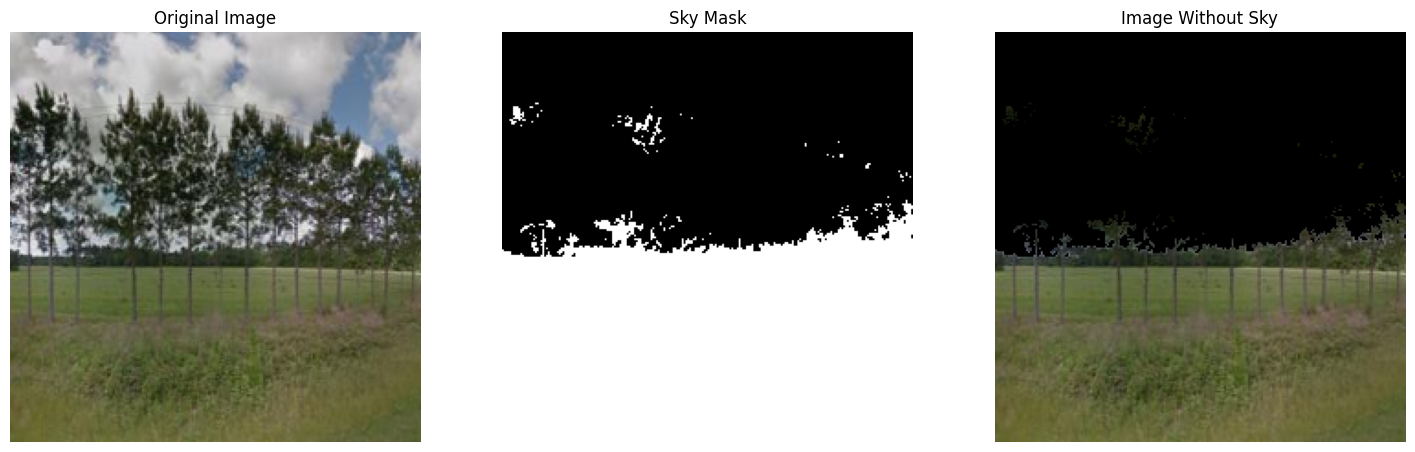

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skyfilter import SkyFilter

# Initialize the sky filter
sky_filter = SkyFilter()

# Process the image array directly
ground_image_no_sky, sky_mask = sky_filter.run_img_array(ground_image_vis)

# sky_mask = cv2.bitwise_not(sky_mask)

# Visualize the original image, mask, and the sky-removed image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(ground_image_vis)
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(sky_mask, cmap='gray')
ax2.set_title("Sky Mask")
ax2.axis('off')

ax3.imshow(ground_image_no_sky)
ax3.set_title("Image Without Sky")
ax3.axis('off')

plt.show()

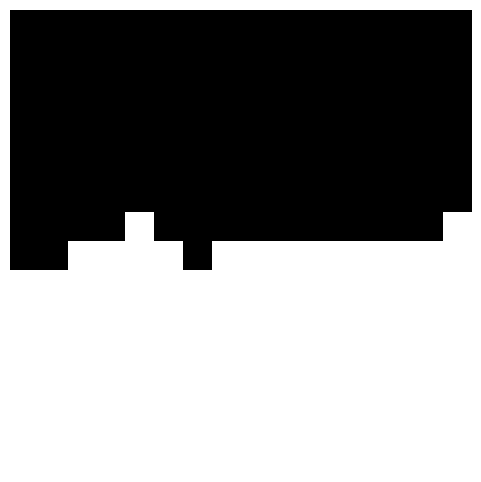

In [67]:
# Define the grid size
grid_size = 16  # This can be changed according to your ViT's grid size

# Dimensions of the image
height, width = ground_image_no_sky.shape[:2]

# Calculate the size of each grid cell
cell_height = height // grid_size
cell_width = width // grid_size

# Initialize the grid mask
grid_mask = np.zeros((grid_size, grid_size), dtype=np.uint8)

# Loop over each cell in the grid
for i in range(grid_size):
    for j in range(grid_size):
        # Define the region of interest (ROI) for this cell
        start_x = j * cell_width
        start_y = i * cell_height
        end_x = (j + 1) * cell_width if j < grid_size - 1 else width
        end_y = (i + 1) * cell_height if i < grid_size - 1 else height
        
        # Extract the cell from the sky mask
        cell = sky_mask[start_y:end_y, start_x:end_x]
        
        # Apply majority voting: if more than half of the cell is sky, mark it as sky
        if np.mean(cell) > 127:  # Since the mask is binary, 127 is the midpoint
            grid_mask[i, j] = 1  # Mark as ground
        else:
            grid_mask[i, j] = 0  # Mark as ground

# Visualize the grid mask
plt.figure(figsize=(6, 6))
plt.imshow(grid_mask, cmap='gray')
# plt.title("Grid Mask")
plt.axis('off')
plt.show()

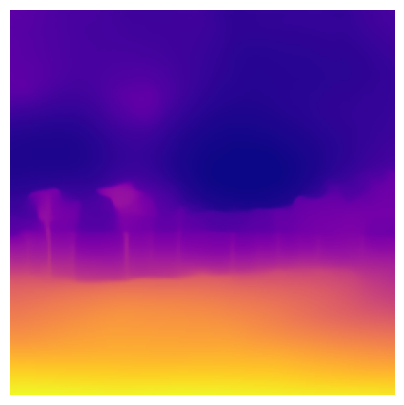

In [68]:
# Initialize the depth estimation model
def apply_depth_estimation(model, image_processor, image, grid_size=16, debug=False):
    """
    Applies depth estimation to the image, and returns the depth map along with
    a downsampled version of the depth map on a 16x16 grid where each grid cell
    contains the average depth value of the pixels in that cell.
    
    Parameters:
    - model: The depth estimation model.
    - image_processor: The processor for the depth estimation model.
    - image: The image to be processed for depth estimation.
    - grid_size: The size of the token grid (default is 16).
    - debug: Enable visualization of intermediate steps (default is False).

    Returns:
    - depth_map: The estimated depth map for the image.
    - depth_map_grid: The downsampled 16x16 depth map, containing average depth values.
    """
    # Prepare image for the model
    inputs = image_processor(images=image, return_tensors="pt")

    # Dimensions of the image
    height, width = image.shape[:2]

    # Get the predicted depth
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # Interpolate to the original image size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.shape[:2][::-1],  # [width, height]
        mode="bicubic",
        align_corners=False,
    )

    # Convert the tensor to a NumPy array and remove extra dimensions
    depth_map = prediction.squeeze().cpu().numpy()

    # Normalize the depth map to the range [0, 1]
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

    # Calculate the size of each grid cell
    cell_height = height // grid_size
    cell_width = width // grid_size

    # Create the downsampled depth map grid
    depth_map_grid = np.zeros((grid_size, grid_size), dtype=np.float32)
    for i in range(grid_size):
        for j in range(grid_size):
            start_x = j * cell_width
            start_y = i * cell_height
            end_x = (j + 1) * cell_width if j < grid_size - 1 else width
            end_y = (i + 1) * cell_height if i < grid_size - 1 else height
            
            # Calculate the average depth value in the cell
            cell_depth = depth_map[start_y:end_y, start_x:end_x]
            depth_map_grid[i, j] = np.mean(cell_depth)

    # Visualize the depth map and downsampled depth map grid if in debug mode
    if debug:
        plt.figure(figsize=(18, 8))
        plt.subplot(131)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(depth_map, cmap='plasma')
        plt.colorbar()
        plt.title('Depth Map')
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(depth_map_grid, cmap='plasma')
        plt.colorbar()
        plt.title('Downsampled Depth Map (16x16 Grid)')
        plt.axis('off')
        plt.show()

    return depth_map, depth_map_grid

image_processor_depth = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

depth_map, depth_map_grid = apply_depth_estimation(depth_model, image_processor_depth, ground_image_no_sky, grid_size=grid_size, debug=False)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(depth_map, cmap='plasma')
ax.axis('off')
plt.savefig(os.path.join("images", "depth_map.png"), dpi=300, bbox_inches='tight')
plt.show()

normalized_features1.shape: (256, 768)
normalized_features2.shape: (256, 768)
grid_size: 16
averaged_vertical_tokens.shape: (16, 768)
averaged_radial_tokens.shape: (64, 768)
Min Distance: 0.8744 	Best Orientation: 0.0°
Min Distance: 0.8725 	Best Orientation: 5.625°
Min Distance: 0.8708 	Best Orientation: 11.25°
Min Distance: 0.8682 	Best Orientation: 16.875°
Confidence: 1.7366


C:\Users\russ_le\AppData\Local\Temp\ipykernel_28652\733212751.py:133: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  end_x_GT = int(center[0] + radius * np.cos(np.deg2rad(90 - (yaw - 180))))
C:\Users\russ_le\AppData\Local\Temp\ipykernel_28652\733212751.py:134: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  end_y_GT = int(center[1] - radius * np.sin(np.deg2rad(90 - (yaw - 180))))


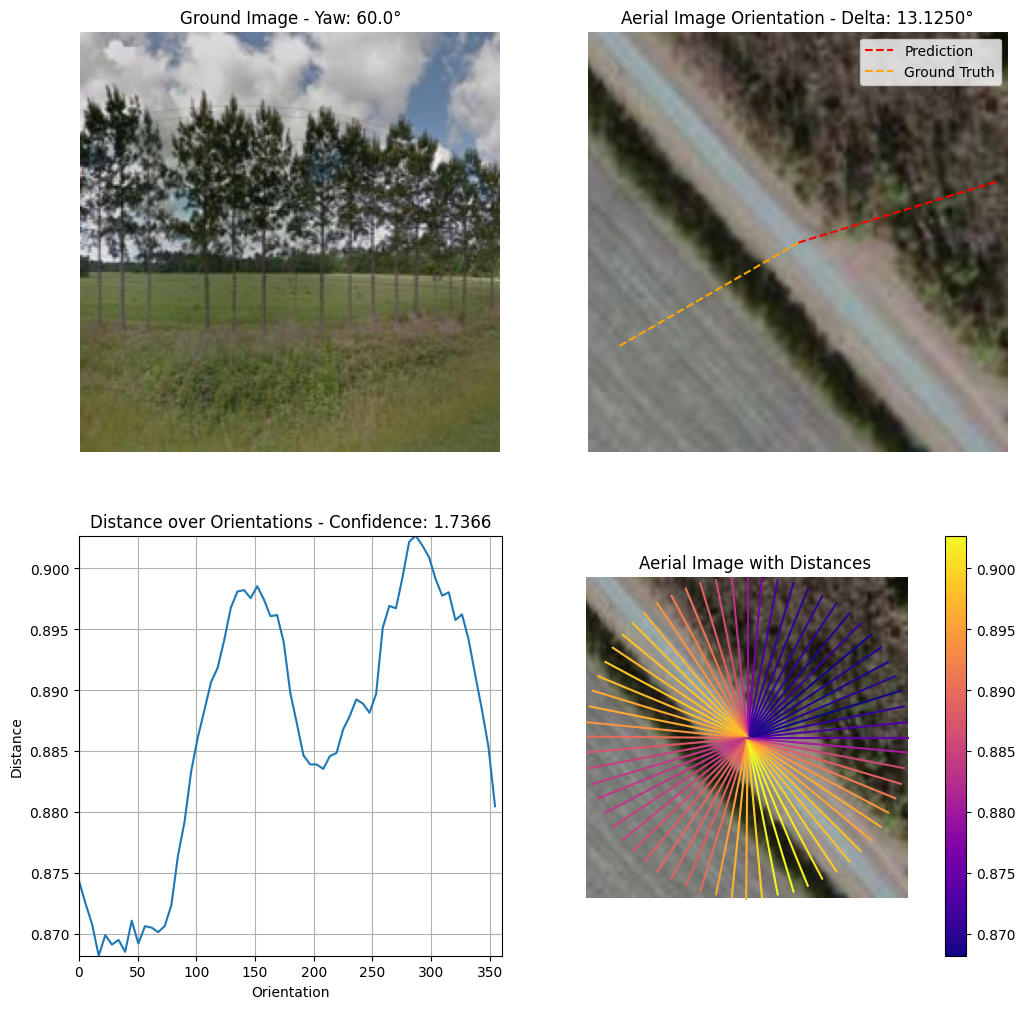

In [69]:
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

# Normalize the features
normalized_features1 = normalize(tokens_1, axis=1)
normalized_features2 = normalize(tokens_2, axis=1)
print("normalized_features1.shape:", normalized_features1.shape)
print("normalized_features2.shape:", normalized_features2.shape)

grid_size = int(np.sqrt(normalized_features1.shape[0]))  # assuming square grid
print("grid_size:", grid_size)

# Create results directory if it doesn't exist
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

image_span = 90                     # horizontal fov in degrees
angle_step = image_span / grid_size

# Function to get tokens along a direction (vertical or radial)
def get_direction_tokens(tokens, angle=None, vertical_idx=None, grid_size=16):
    if angle is not None:  # Radial direction
        center = (grid_size // 2, grid_size // 2)
        direction_tokens = []
        indices = []
        for r in range(grid_size):
            delta = 0
            x = int(center[0] + (r+delta) * np.cos(np.deg2rad(angle)))
            y = int(center[1] - (r+delta) * np.sin(np.deg2rad(angle)))
            if 0 <= x < grid_size and 0 <= y < grid_size:
                idx = y * grid_size + x
                if idx < tokens.shape[0]:  # Ensure index is within bounds
                    direction_tokens.append(tokens[idx])
                    indices.append((y, x))
                else:
                    break  # Stop if out of bounds
            else:
                break  # Stop if out of bounds
        return np.array(direction_tokens), indices
    elif vertical_idx is not None:  # Vertical line
        direction_tokens = tokens[vertical_idx::grid_size]  # extract each vertical line
        return direction_tokens, [(i, vertical_idx) for i in range(grid_size)]

# Compute Averaged Tokens using the weight vector, excluding sky tokens
averaged_vertical_tokens = []
for i in range(grid_size):
    vertical_tokens, indices = get_direction_tokens(normalized_features1, vertical_idx=i, grid_size=grid_size)
    valid_tokens = []
    valid_weights = []
    for token, (y, x) in zip(vertical_tokens, indices):
        if grid_mask[y, x] == 1:  # 1 indicates ground, 0 indicates sky
            valid_tokens.append(token)
            valid_weights.append(1.0)  # You can adjust the weights if needed
    
    if valid_tokens:
        valid_tokens = np.array(valid_tokens)
        valid_weights = np.array(valid_weights)
        valid_weights /= np.sum(valid_weights)  # Normalize the weights
        
        # Calculate weighted average only on valid (non-sky) tokens
        weighted_avg = np.average(valid_tokens, axis=0, weights=valid_weights)
        averaged_vertical_tokens.append(weighted_avg)
    else:
        # If no valid tokens are found (i.e., entire column is sky), append a zero vector or any placeholder
        averaged_vertical_tokens.append(np.zeros_like(vertical_tokens[0]))
averaged_vertical_tokens = np.array(averaged_vertical_tokens)


averaged_radial_tokens = []
for beta in np.arange(0, 360, angle_step):
    radial_tokens, _ = get_direction_tokens(normalized_features2, angle=beta, grid_size=grid_size)
    # increasing_weights = np.linspace(0.1, 1, len(radial_tokens))
    increasing_weights = np.linspace(1, 1, len(radial_tokens))
    increasing_weights /= np.sum(increasing_weights)
    weighted_avg = np.average(radial_tokens, axis=0, weights=increasing_weights)
    averaged_radial_tokens.append(weighted_avg)
averaged_radial_tokens = np.array(averaged_radial_tokens)

print("averaged_vertical_tokens.shape:", averaged_vertical_tokens.shape)
print("averaged_radial_tokens.shape:", averaged_radial_tokens.shape)

# Function to calculate global minimum cosine distance
def find_alignment(averaged_vertical_tokens, averaged_radial_tokens, grid_size, image_span):
    
    angle_step = image_span / grid_size
    min_distance = float('inf')
    distances = []

    for j, beta in enumerate(np.arange(0, 360, angle_step)):
        cone_distance = 0
        for i in range(grid_size+1):

            vertical_token = averaged_vertical_tokens[(grid_size-1)-i]
            radial_token = averaged_radial_tokens[int(j + i - grid_size/2) % averaged_radial_tokens.shape[0]]
            # print(f"beta: {beta:.2f} \tangle: {(j + i - grid_size/2)*angle_step} \tindex: {int(j + i - grid_size/2) % averaged_radial_tokens.shape[0]}")       

            cone_distance += (1 - np.dot(vertical_token, radial_token))  # Cosine distance
            # cone_distance += np.linalg.norm(vertical_token - radial_token)  # Euclidean distance

        cone_distance /= grid_size
        if cone_distance < min_distance:
            min_distance = cone_distance
            best_orientation = beta
            print(f"Min Distance: {min_distance:.4f} \tBest Orientation: {best_orientation}°")
        distances.append(cone_distance)

    # Compute confidence
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    confidence = (mean_distance - min_distance) / std_distance  # Z-score

    return best_orientation, distances, min_distance, confidence


# Find the best alignment
best_orientation, distances, min_distance, confidence = find_alignment(averaged_vertical_tokens, averaged_radial_tokens, grid_size, image_span)

print(f"Confidence: {confidence:.4f}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

ax1.imshow(ground_image_np)
ax1.set_title("Ground Image - Yaw: {:.1f}°".format(yaw[0]))
ax1.axis('off')

ax2.imshow(aerial_image_np)
radius = aerial_image_np.shape[0] // 2
center = (aerial_image_np.shape[1] // 2, aerial_image_np.shape[0] // 2)
end_x = int(center[0] + radius * np.cos(np.deg2rad(best_orientation)))
end_y = int(center[1] - radius * np.sin(np.deg2rad(best_orientation)))
end_x_GT = int(center[0] + radius * np.cos(np.deg2rad(90 - (yaw - 180))))
end_y_GT = int(center[1] - radius * np.sin(np.deg2rad(90 - (yaw - 180))))
line_pred = ax2.plot([center[0], end_x], [center[1], end_y], color='red', linestyle='--', label='Prediction')
line_gt = ax2.plot([center[0], end_x_GT], [center[1], end_y_GT], color='orange', linestyle='--', label='Ground Truth')
delta_yaw = ((90 - (yaw[0] - 180)) - best_orientation) % 180
if delta_yaw < 0:
    delta_yaw += 180
ax2.set_title("Aerial Image Orientation - Delta: {:.4f}°".format(delta_yaw))
ax2.legend(loc='upper right')
ax2.axis('off')

ax3.plot(np.arange(0, 360, angle_step), distances)
ax3.set_title("Distance over Orientations - Confidence: {:.4f}".format(confidence))
ax3.grid(True)
ax3.set_xlabel('Orientation')
ax3.set_ylabel('Distance')
ax3.set_xlim(0, 360)
ax3.set_ylim(min(distances), max(distances))

ax4.imshow(aerial_image_np)
radius = aerial_image_np.shape[0] // 2
center = (aerial_image_np.shape[1] // 2, aerial_image_np.shape[0] // 2)
min_dist = min(distances)
max_dist = max(distances)
for j, beta in enumerate(np.arange(0, 360, angle_step)):
    end_x = int(center[0] + radius * np.cos(np.deg2rad(beta)))
    end_y = int(center[1] - radius * np.sin(np.deg2rad(beta)))
    color = plt.cm.plasma((distances[j] - min_dist) / (max_dist - min_dist))  # Normalize distances for color map
    ax4.plot([center[0], end_x], [center[1], end_y], color=color)
ax4.set_title("Aerial Image with Distances")
ax4.axis('off')

norm = plt.Normalize(min_dist, max_dist)
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax4)

# Determine the next available file number
file_count = len([name for name in os.listdir(results_dir) if name.startswith("summary") and name.endswith(".png")])
file_path = os.path.join(results_dir, f"summary_{file_count}.png")

# Save the figure
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8284271247461903..1.4142135623730951].


Tokenized depth visualization saved to: images\tokenized_depth_visualization.png


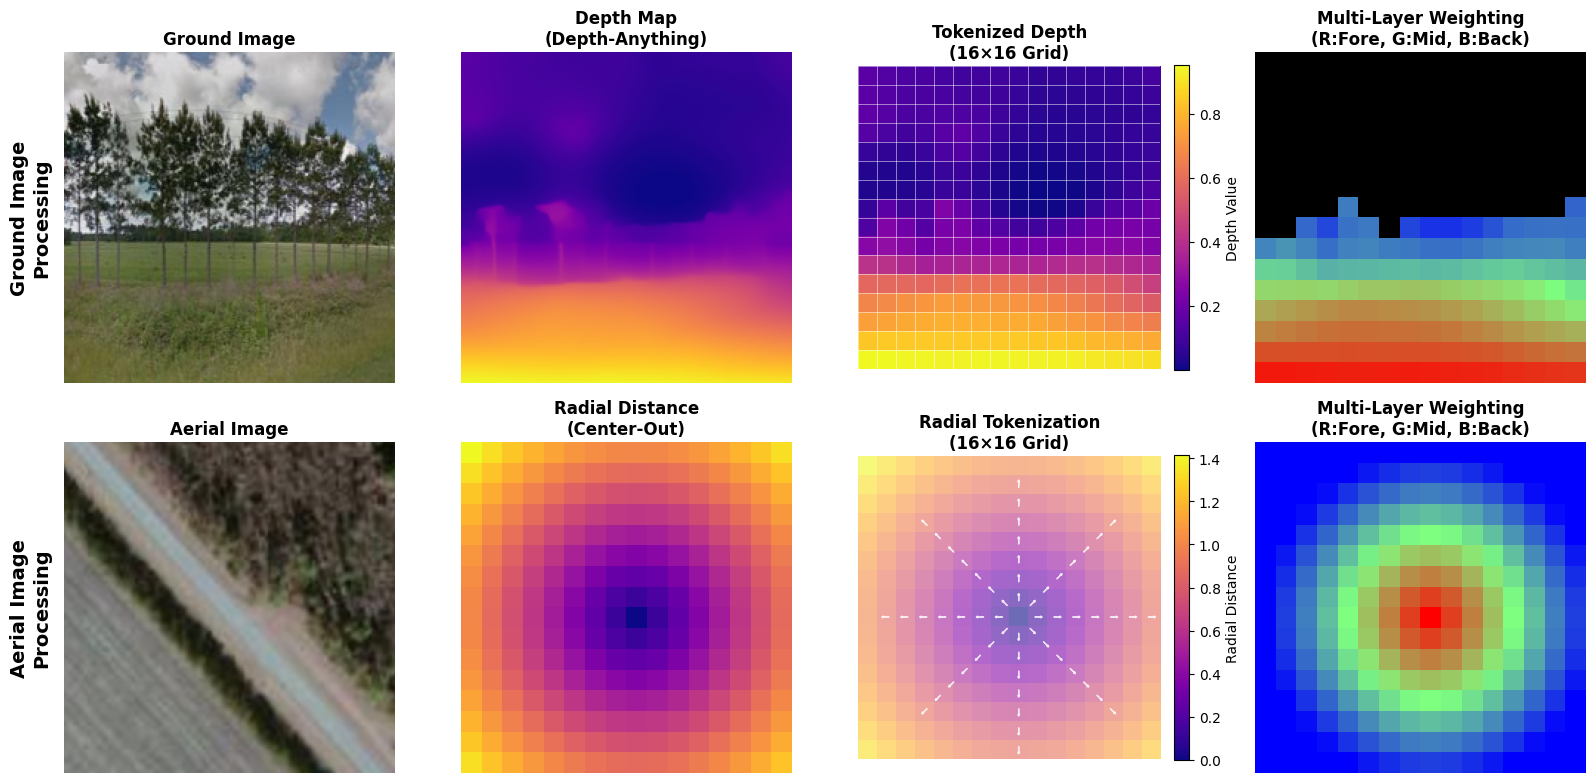

In [70]:
# Tokenized Depth Map Visualization for Paper
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def create_tokenized_depth_visualization(depth_map_grid, sky_grid, grid_size, save_path=None):
    """
    Creates a comprehensive visualization showing how depth information is tokenized
    and applied to both ground and aerial image tokens for the paper method section.
    """
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: Ground Image Processing
    # Original Ground Image
    axes[0, 0].imshow(ground_image_vis)
    axes[0, 0].set_title('Ground Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Depth Map
    axes[0, 1].imshow(depth_map, cmap='plasma')
    axes[0, 1].set_title('Depth Map\n(Depth-Anything)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Tokenized Depth Grid
    im1 = axes[0, 2].imshow(depth_map_grid, cmap='plasma', interpolation='nearest')
    axes[0, 2].set_title(f'Tokenized Depth\n({grid_size}×{grid_size} Grid)', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Add grid lines to show tokenization
    for i in range(grid_size + 1):
        axes[0, 2].axhline(i - 0.5, color='white', linewidth=0.5, alpha=0.7)
        axes[0, 2].axvline(i - 0.5, color='white', linewidth=0.5, alpha=0.7)
    
    # Depth-Weighted Token Visualization
    # Create a visualization showing foreground/middleground/background layers
    depth_layers = np.zeros((grid_size, grid_size, 3))
    for i in range(grid_size):
        for j in range(grid_size):
            if sky_grid[i, j] == 1:  # Non-sky tokens
                d = depth_map_grid[i, j]
                # Foreground (close): Red channel = depth value
                depth_layers[i, j, 0] = d
                # Middleground: Green channel = triangular weighting
                depth_layers[i, j, 1] = 1 - abs(d - 0.5) * 2
                # Background (far): Blue channel = 1 - depth value  
                depth_layers[i, j, 2] = 1 - d
    
    axes[0, 3].imshow(depth_layers)
    axes[0, 3].set_title('Multi-Layer Weighting\n(R:Fore, G:Mid, B:Back)', fontsize=12, fontweight='bold')
    axes[0, 3].axis('off')
    
    # Row 2: Aerial Image Processing
    # Original Aerial Image
    axes[1, 0].imshow(aerial_image_vis)
    axes[1, 0].set_title('Aerial Image', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Radial Distance Map
    center = (grid_size // 2, grid_size // 2)
    radial_distance_grid = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            distance = np.sqrt((i - center[0])**2 + (j - center[1])**2)
            radial_distance_grid[i, j] = distance / (grid_size // 2)  # Normalize to [0, 1]
    
    im2 = axes[1, 1].imshow(radial_distance_grid, cmap='plasma', interpolation='nearest')
    axes[1, 1].set_title('Radial Distance\n(Center-Out)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    # Tokenized Radial Grid with directional arrows
    axes[1, 2].imshow(radial_distance_grid, cmap='plasma', alpha=0.6, interpolation='nearest')
    
    # Add radial direction arrows
    center_x, center_y = grid_size // 2, grid_size // 2
    angles = np.arange(0, 360, 45)  # Every 45 degrees
    for angle in angles:
        for r in range(1, grid_size // 2):
            x = center_x + r * np.cos(np.deg2rad(angle))
            y = center_y - r * np.sin(np.deg2rad(angle))
            if 0 <= x < grid_size and 0 <= y < grid_size:
                # Draw small arrows
                dx = 0.3 * np.cos(np.deg2rad(angle))
                dy = -0.3 * np.sin(np.deg2rad(angle))
                axes[1, 2].arrow(x - dx/2, y - dy/2, dx, dy, 
                               head_width=0.1, head_length=0.1, 
                               fc='white', ec='white', alpha=0.8)
    
    axes[1, 2].set_title(f'Radial Tokenization\n({grid_size}×{grid_size} Grid)', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    # Radial-Weighted Token Visualization
    radial_layers = np.zeros((grid_size, grid_size, 3))
    for i in range(grid_size):
        for j in range(grid_size):
            r = radial_distance_grid[i, j]
            # Foreground (center): Red channel = 1 - radial distance
            radial_layers[i, j, 0] = 1 - r
            # Middleground: Green channel = triangular weighting
            radial_layers[i, j, 1] = 1 - abs(r - 0.5) * 2
            # Background (edge): Blue channel = radial distance
            radial_layers[i, j, 2] = r
    
    axes[1, 3].imshow(radial_layers)
    axes[1, 3].set_title('Multi-Layer Weighting\n(R:Fore, G:Mid, B:Back)', fontsize=12, fontweight='bold')
    axes[1, 3].axis('off')
    
    # Add colorbar for depth/distance reference
    cbar1 = plt.colorbar(im1, ax=axes[0, 2], fraction=0.046, pad=0.04)
    cbar1.set_label('Depth Value', fontsize=10)
    
    cbar2 = plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)
    cbar2.set_label('Radial Distance', fontsize=10)
    
    # Add row labels
    axes[0, 0].text(-0.1, 0.5, 'Ground Image\nProcessing', fontsize=14, fontweight='bold', 
                   transform=axes[0, 0].transAxes, rotation=90, ha='center', va='center')
    axes[1, 0].text(-0.1, 0.5, 'Aerial Image\nProcessing', fontsize=14, fontweight='bold', 
                   transform=axes[1, 0].transAxes, rotation=90, ha='center', va='center')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Tokenized depth visualization saved to: {save_path}")
    
    plt.show()
    
    return fig

# Create the visualization
fig = create_tokenized_depth_visualization(
    depth_map_grid, 
    grid_mask, 
    grid_size, 
    save_path=os.path.join("images", "tokenized_depth_visualization.png")
)

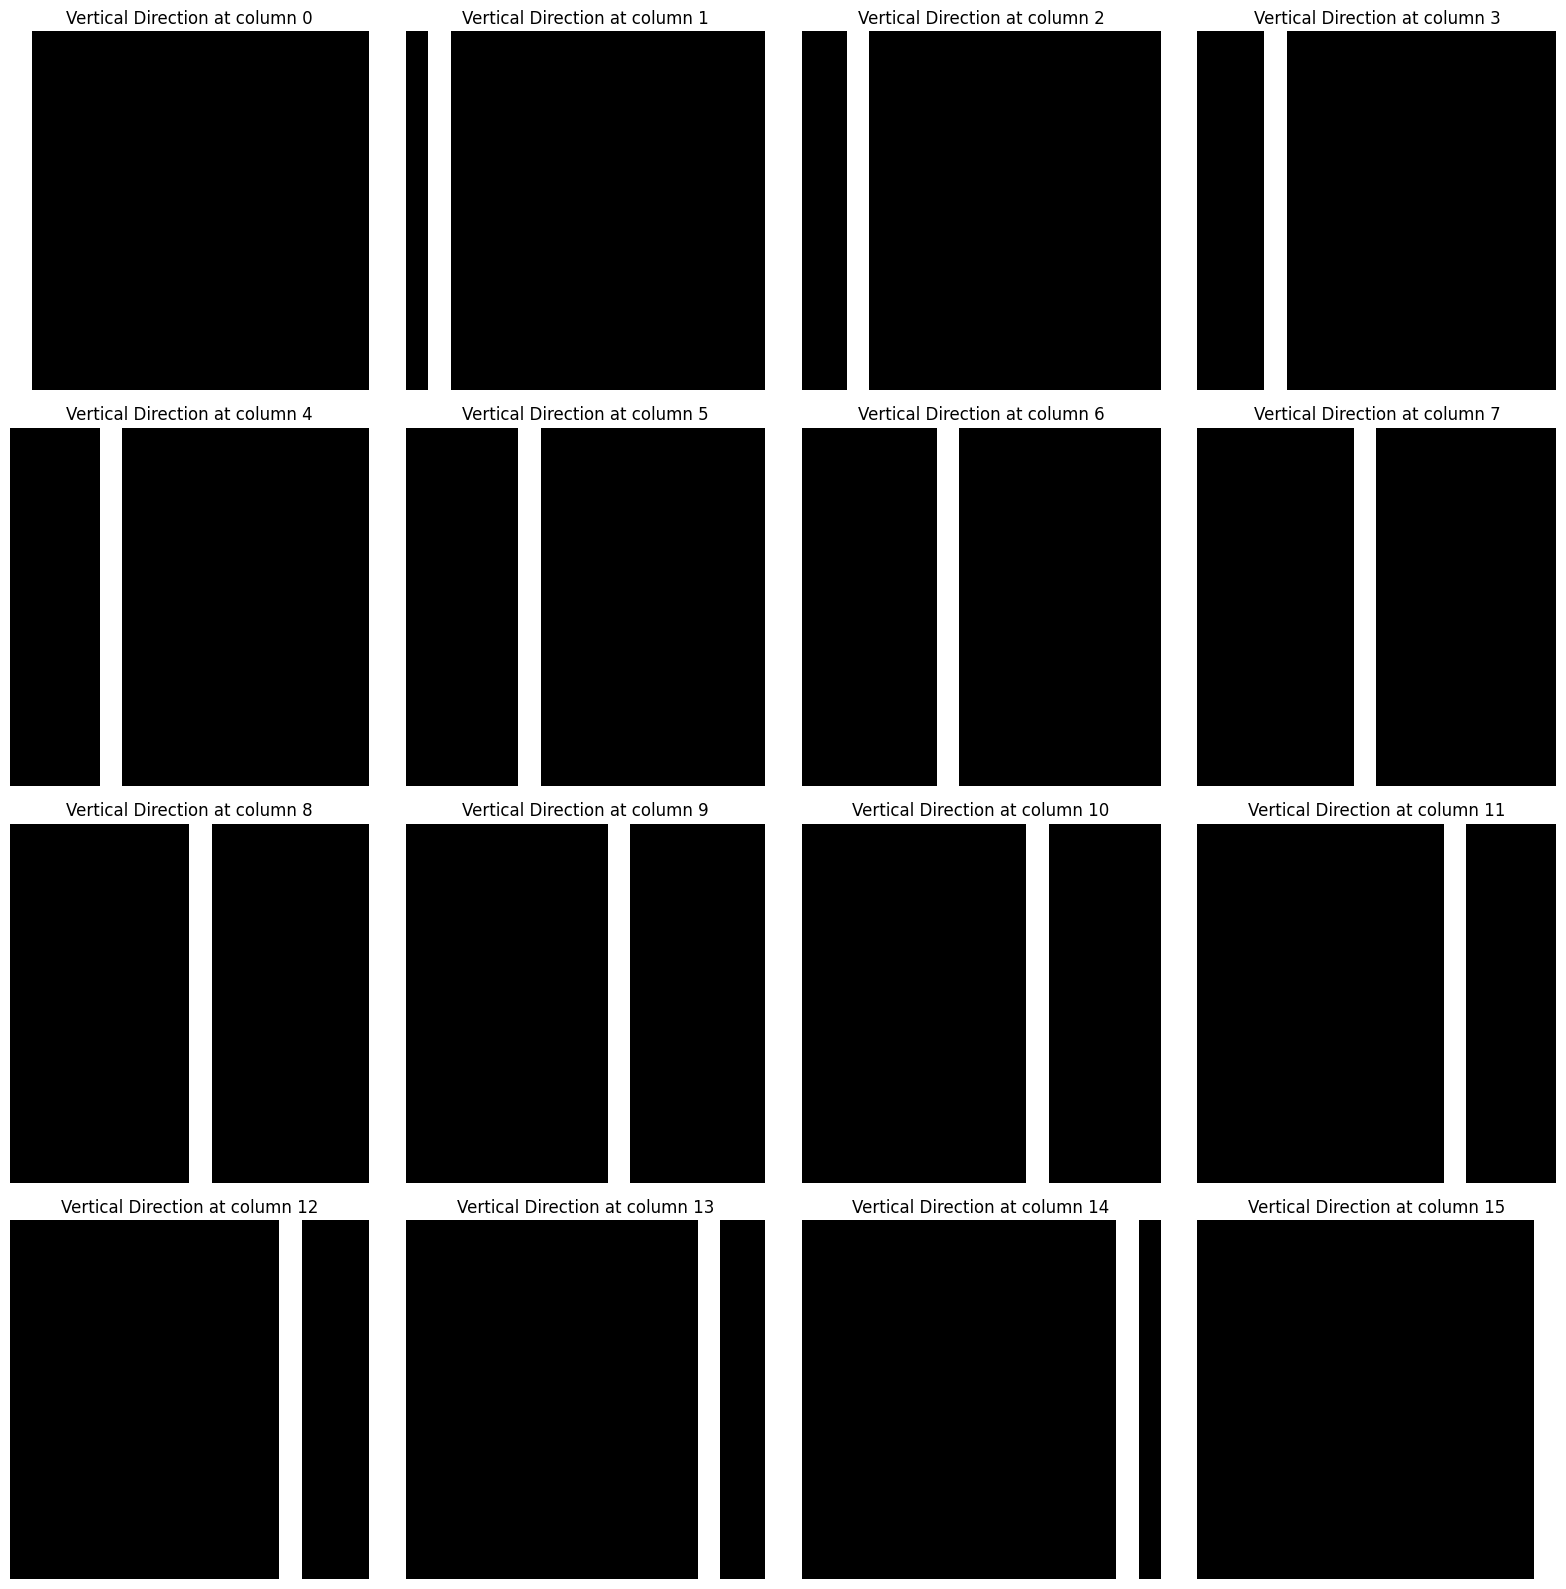

len(angles): 16


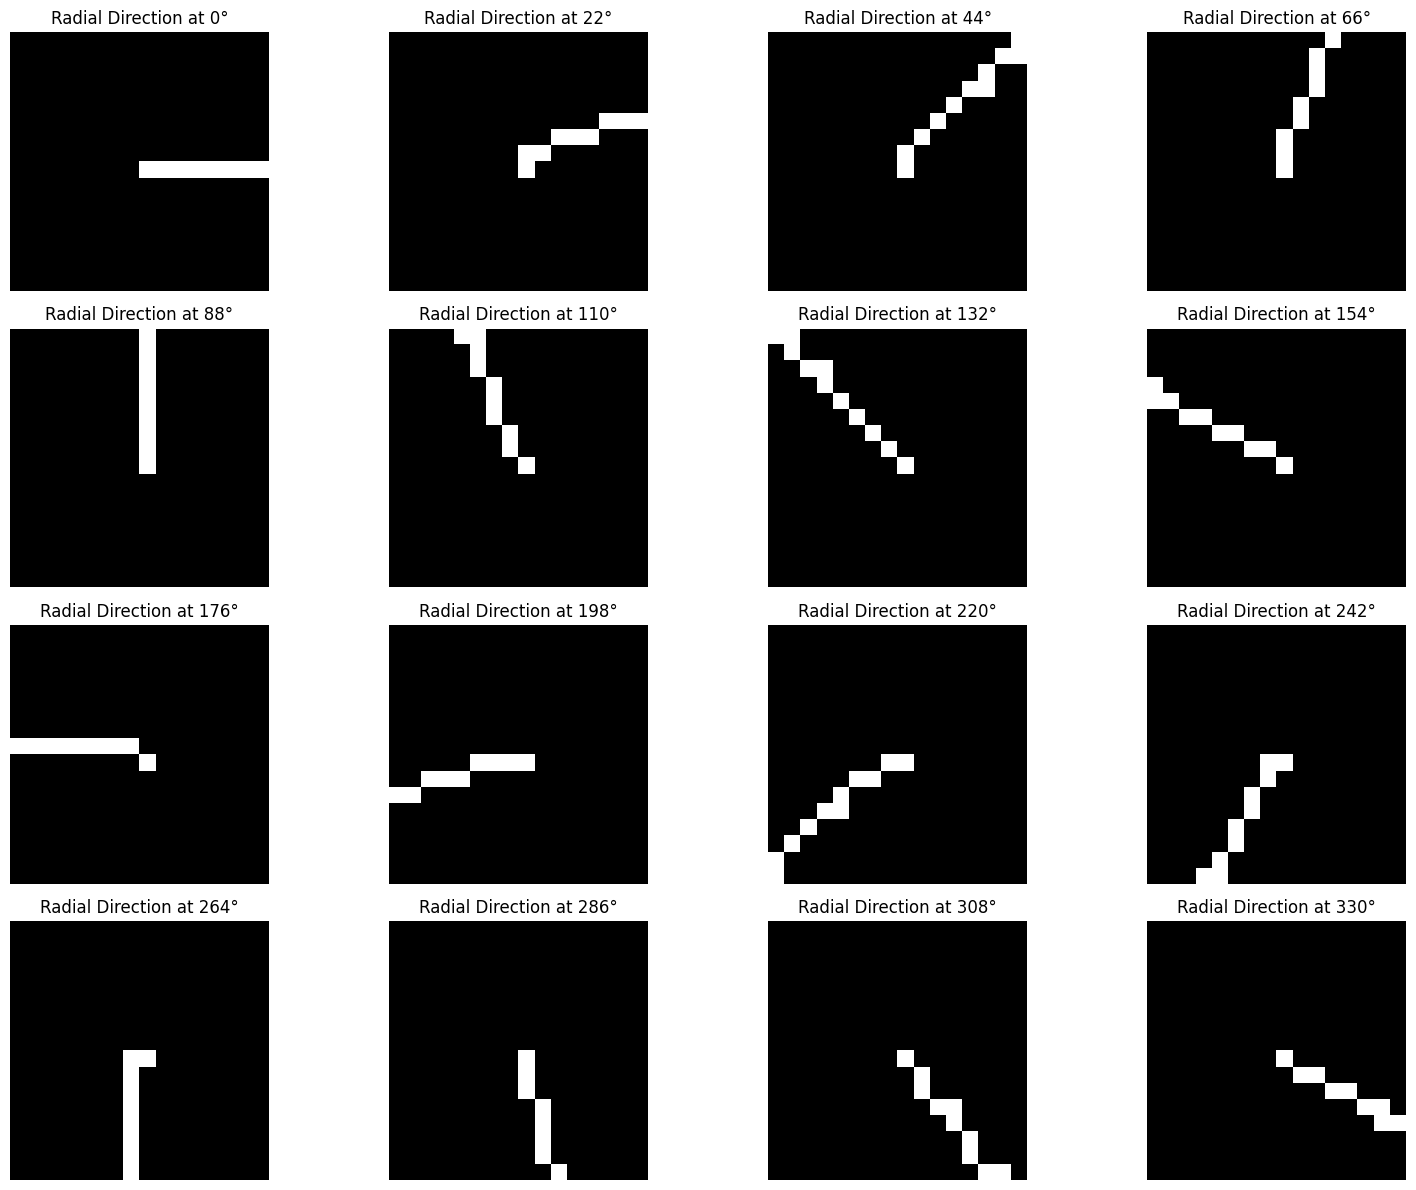

In [71]:
# Visualization of vertical direction tokens
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for i in range(grid_size):
    grid = np.zeros((grid_size, grid_size))
    for y in range(grid_size):
        grid[y, i] = 1  # Highlight the tokens in the vertical direction

    ax = axes[i]
    ax.imshow(grid, cmap='gray')
    ax.set_title(f"Vertical Direction at column {i}")
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join("utils", "vertical_directions.png"), dpi=300, bbox_inches='tight')
plt.show()



# Visualization of radial direction tokens
angles = [angle for angle in range(0, 360-grid_size, int(360/grid_size))]
print("len(angles):", len(angles))
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, angle in enumerate(angles):
    _, indices = get_direction_tokens(normalized_features2, angle=angle, grid_size=grid_size)
    grid = np.zeros((grid_size, grid_size))
    for (y, x) in indices:
        grid[y, x] = 1  # Highlight the tokens in the radial direction

    ax = axes[i]
    ax.imshow(grid, cmap='gray')
    ax.set_title(f"Radial Direction at {angle}°")
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join("utils", "radial_directions.png"), dpi=300, bbox_inches='tight')
plt.show()

normalized_features1.shape: (256, 768)
normalized_features2.shape: (256, 768)
Selected index from aerial features:  232


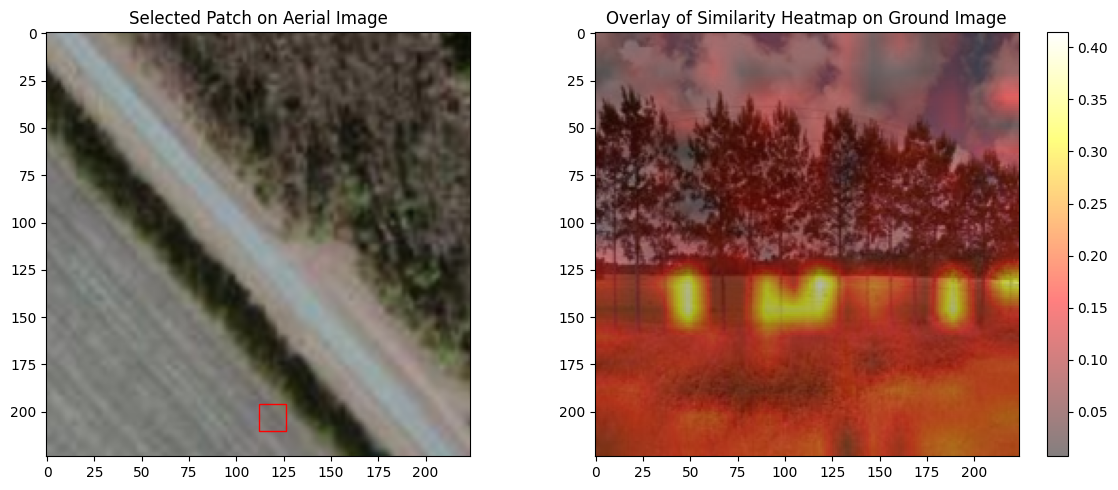

In [72]:
from sklearn.preprocessing import normalize

# Normalize the features
normalized_features1 = normalize(tokens_1, axis=1)
normalized_features2 = normalize(tokens_2, axis=1)
print("normalized_features1.shape:", normalized_features1.shape)
print("normalized_features2.shape:", normalized_features2.shape)

# Take one element from features2 (aerial image features)
random_index = np.random.randint(0, tokens_2.shape[0])
selected_feature = normalized_features2[random_index]
print("Selected index from aerial features: ", random_index)

# Show which small piece of the aerial image was chosen
row_aerial, col_aerial = dm.idx_to_source_position(random_index, grid_size2, resize_scale2)
selected_patch_size = dm.model.patch_size * resize_scale2

# Compute the distance (inner product) between this element and all elements of features1 (ground image features)
distances = np.dot(normalized_features1, selected_feature)

# Reshape into the appropriate dimensions for the ground image
reshaped_distances = distances.reshape(grid_size1)

# Resize the heatmap to fit the ground image
resized_heatmap = cv2.resize(reshaped_distances, (ground_image_vis.shape[1], ground_image_vis.shape[0]))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(aerial_image_vis)
rect = plt.Rectangle((col_aerial - selected_patch_size / 2, row_aerial - selected_patch_size / 2),
                     selected_patch_size, selected_patch_size,
                     linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax1.set_title('Selected Patch on Aerial Image')
alpha = 0.5
ax2.imshow(ground_image_vis)
img2 = ax2.imshow(resized_heatmap, cmap='hot', interpolation='nearest', alpha=alpha)
fig.colorbar(img2, ax=ax2)
ax2.set_title('Overlay of Similarity Heatmap on Ground Image')
fig.tight_layout()